Mounted at /content/drive
Numeric features: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical features: ['model', 'transmission', 'fuelType', 'Make']

        NEURAL NETWORK ACCURACY COMPARISON


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 359481408.0000 - val_loss: 369075488.0000
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 366369120.0000 - val_loss: 366916224.0000
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 364037600.0000 - val_loss: 363571456.0000
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 356819872.0000 - val_loss: 359209856.0000
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 355098752.0000 - val_loss: 353957024.0000
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 352182912.0000 - val_loss: 347954048.0000
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 334003360.0000 - val_loss: 341245760.0000
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 330041504.0000 - val_loss: 333945312.0000
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 337290624.0000 - val_loss: 326171968.0000
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 321137056.0000 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

        Final Model Smmary       
Accuracy : 78.39%


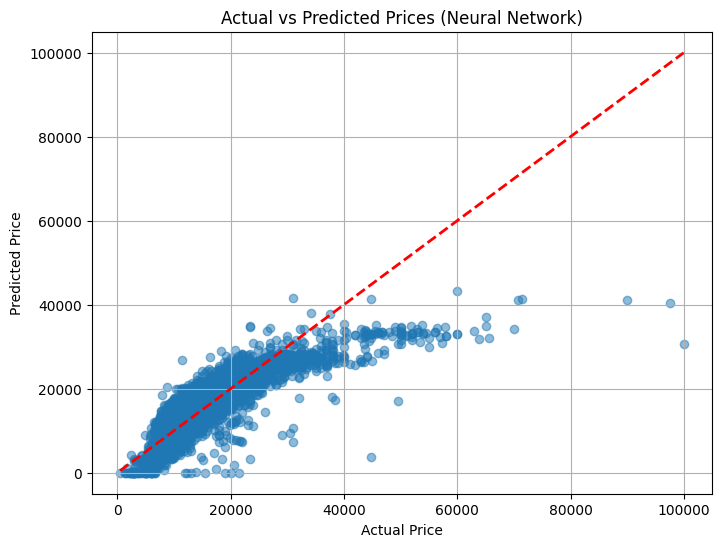

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

from google.colab import drive
drive.mount('/content/drive')


# 1. Load Dataset
file_path = '/content/drive/MyDrive/cars_dataset_20k.csv'
df = pd.read_csv(file_path)

# 2. Features & Target
X = df.drop('price', axis=1)
y = df['price']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


# 3. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

#  Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


#  Model Builder Function
def build_model(input_dim):
    model = Sequential()

    model.add(Dense(16, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))

    # model.add(Dense(9, activation='relu'))
    # model.add(Dropout(0.2))

    # model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # optimizer = SGD(learning_rate=0.01) # Stochastic

    model.compile(
        # optimizer=optimizer,
        optimizer="adam",
        loss='mean_squared_error'
    )

    return model


# 6. Train with Different Epochs & Batch Sizes
configs = [
    (50, 32)
    # (150, 64),
    # (300, 512),
    # (300, 32),
]

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("\n" + "="*65)
print("        NEURAL NETWORK ACCURACY COMPARISON")
print("="*65)

results = []

for epochs, batch_size in configs:

    model = build_model(X_train_transformed.shape[1])

    model.fit(
        X_train_transformed,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test_transformed).flatten()

    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - mape

    print(
        f"Accuracy with {epochs} epochs "
        f"and {batch_size} batch size: "

    )

    results.append([epochs, batch_size, accuracy])

print("="*65)


# 7. Results Table
results_df = pd.DataFrame(
    results,
    columns=["Epochs", "Batch Size", "Accuracy (%)"]
)

print("\n--- Summary Table ---")
print(results_df)


best_run = results_df.sort_values(by="Accuracy (%)", ascending=False).iloc[0]

#  Extract the best parameters automatically
best_epochs = int(best_run["Epochs"])
best_batch_size = int(best_run["Batch Size"])
best_accuracy = best_run["Accuracy (%)"]

print(f"\nWINNER CONFIGURATION:")
print(f"Epochs: {best_epochs}")
print(f"Batch Size: {best_batch_size}")
print(f"Achieved Accuracy: {best_accuracy:.2f}%")


print(f"Achieved Accuracy: {best_accuracy:.2f}%")

print(f"\nRetraining the best model ({best_epochs} epochs, {best_batch_size} batch)...")

final_model = build_model(X_train_transformed.shape[1])

final_model.fit(
    X_train_transformed,
    y_train,
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

y_pred = final_model.predict(X_test_transformed).flatten()






# 9. Final Evaluation
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print("\n" + "="*40)
print("        Final Model Smmary       ")
print("="*40)
print(f"Accuracy : {accuracy:.2f}%")
print("="*40)


# 10. Visualization

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    linewidth=2
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Neural Network)")
plt.grid(True)
plt.show()



**Random Forest**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Numeric features: ['year', 'mileage', 'tax', 'mpg', 'engineSize']
Categorical features: ['model', 'transmission', 'fuelType', 'Make']

       🏆 BEST MODEL PARAMETERS       
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

       📊 MODEL PERFORMANCE REPORT       
Accuracy:     91.95%
R2 Score:     0.9355

       🏆 BEST MODEL PARAMETERS       
max_depth           : None
min_samples_split   : 5
n_estimators        : 200

--- First 10 Predictions ---
   Actual     Predicted   Difference    Error %
0   41989  50991.999075  9002.999075  21.441328
1   16230  16566.678192   336.678192   2.074419
2   21773  23473.299138  1700.299138   7.809209
3   14440  14469.506499    29.506499   0.204339
4   13995  14310.416289   315.416289   2.253778
5   10499   8968.593583 -1530.406417 -14.576687
6    7900   8558.514301   658.514301   8.335624
7   13700  12629.40

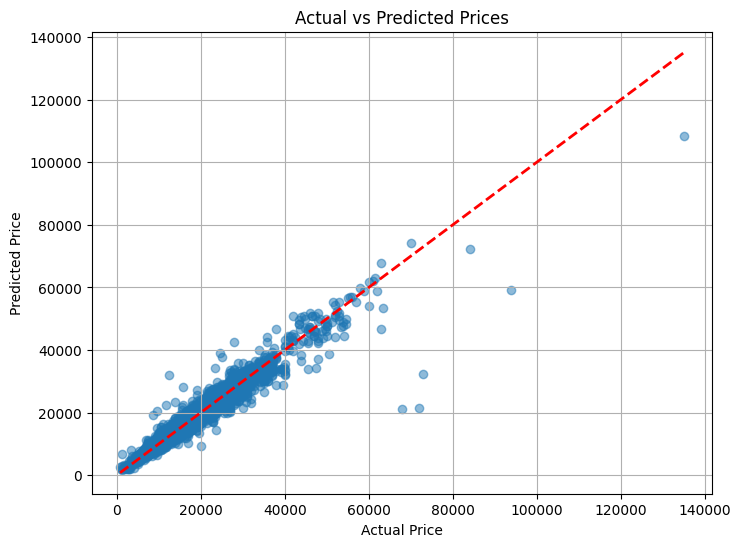

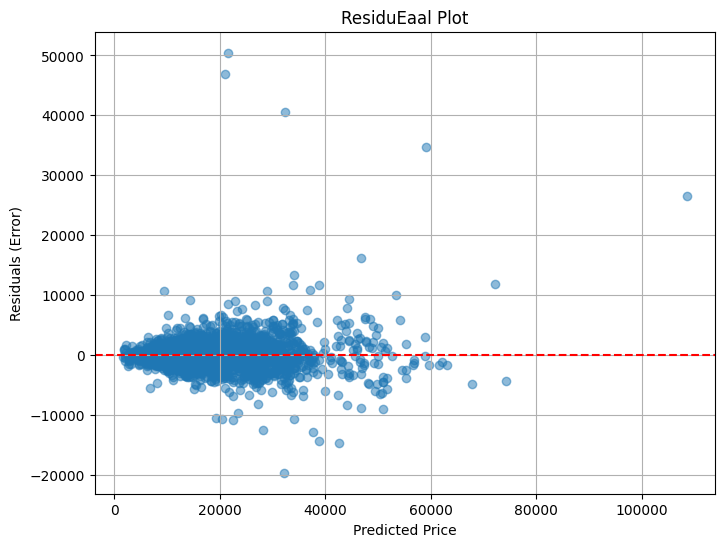

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# 1. Load the Data
file_path = '/content/drive/MyDrive/cars_dataset_20k.csv'
df = pd.read_csv(file_path)


# 2. Features and Target
X = df.drop('price', axis=1)
y = df['price']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 3. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 4. Train/Test Split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

# 5. RandomForest

X_train_transformed = preprocessor.fit_transform(X_train)



rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# param_grid = {
#     'n_estimators': [50, 100, 200]
# }

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train_transformed, y_train)

best_model = grid_search.best_estimator_

X_test_transformed = preprocessor.transform(X_test)

print("\n" + "="*40)
print("        BEST MODEL PARAMETERS       ")
print("="*40)
print(grid_search.best_params_)
print("="*40)

y_pred = best_model.predict(X_test_transformed)


# 6. Evaluation

r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print("\n" + "="*40)
print("        MODEL PERFORMANCE REPORT       ")
print("="*40)
print(f"Accuracy:     {accuracy:.2f}%")
print(f"R2 Score:     {r2:.4f}")
print("="*40)

# Best Hyperparameters
print("\n" + "="*40)
print("       🏆 BEST MODEL PARAMETERS       ")
print("="*40)
for param, value in grid_search.best_params_.items():
    print(f"{param:<20}: {value}")
print("="*40)
# 7. Comparison Table
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

comparison['Difference'] = comparison['Predicted'] - comparison['Actual']
comparison['Error %'] = (comparison['Difference'] / comparison['Actual']) * 100

print("\n--- First 10 Predictions ---")
print(comparison.head(10))


plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Error)")
plt.title("ResiduEaal Plot")
plt.grid(True)
plt.show()